In [1]:
!nvidia-smi | head -n 32

Sun Apr  1 15:16:33 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   41C    P8    18W / 250W |   8002MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 32%   54C    P2    59W / 250W |    394MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
import os
sys.path.append('../common/')
import utils
import nets
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time
import random
plt.style.use('ggplot')
import traceback
import math
print(tf.__version__)

1.3.0


In [3]:
MODEL_NAME = '4_1_rpn_sigmoid_roi_rpn_joint_gpu'

In [4]:
#REMOTE_WORKER = "grpc://10.109.246.6:2222"
#cluster = tf.train.ClusterSpec({"local": ["10.109.246.6:2222"]})

In [5]:
import pickle
with open('../data/train_val.pkl','rb') as fhdl:
    (train_images,train_bbs,val_images,val_bbs) = pickle.load(fhdl)

In [6]:
BATCH_SIZE = 1

In [7]:
box_tuple = [[16, 16],
 [32, 32],
 [48, 48],
 [64, 64],
 [96, 96],
 [128, 128],
 [192, 192],
 [256, 256],
 [512, 512]]

In [192]:
def rpn_layer(feature_map,k=9,ramda=10):
    mask_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,1 * k),name='mask_input')
    cls_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k),name='cls_input')
    reg_input = tf.placeholder(tf.float32,shape=(BATCH_SIZE,None,None,k * 4),name='reg_input')
    
    with tf.variable_scope('rpn_conv'):
        rpn_hidden = tf.layers.conv2d(feature_map,filters=256,kernel_size=(3,3),padding='same',activation=tf.nn.relu,name='hidden')
        cls_result = tf.layers.conv2d(rpn_hidden,filters=k,kernel_size=(1,1),padding='same',activation=None,name='cls_conv') # [BATCH_SIZE,None,None,4 * k]
        reg_result = tf.layers.conv2d(rpn_hidden,filters=4 * k,kernel_size=(1,1),padding='same',activation=None,name='reg_conv') # [BATCH_SIZE,None,None,4 * k]

    with tf.variable_scope('rpn_loss'):
        #cls_input_reshape = tf.reshape(cls_input,shape=(-1,2))
        #cls_result_reshape = tf.reshape(cls_result,shape=(-1,2))

        #reg_input_reshape = tf.reshape(reg_input,shape=(BATCH_SIZE,-1))
        #reg_result_reshape = tf.reshape(reg_result,shape=(BATCH_SIZE,-1))
        with tf.variable_scope('cls_loss'):
            #cls_loss_unnorm = tf.losses.softmax_cross_entropy(onehot_labels=cls_input_reshape,logits=cls_result_reshape,reduction=tf.losses.Reduction.NONE)
            cls_loss_unnorm = tf.nn.sigmoid_cross_entropy_with_logits(labels=cls_input,logits=cls_result)
            cls_loss_unnorm = tf.multiply(mask_input,cls_loss_unnorm)
            out_debug = cls_loss_unnorm
            cls_loss_unnorm = tf.reduce_sum(cls_loss_unnorm)
            cls_loss = cls_loss_unnorm / BATCH_SIZE
        
        with tf.variable_scope('reg_loss'):
            reg_loss_unnorm = tf.losses.huber_loss(labels=reg_input,predictions=reg_result,reduction=tf.losses.Reduction.NONE)
            reg_loss_unnorm = tf.reshape(reg_loss_unnorm,shape=(-1,4))
            reg_loss_unnorm = tf.reduce_sum(reg_loss_unnorm,axis=-1)
            print(reg_loss_unnorm.shape,cls_input.shape)
            regmask = tf.reshape(cls_input,[-1])
            reg_loss_masked = tf.multiply(reg_loss_unnorm ,regmask)
            reg_loss_unnorm_sum = tf.reduce_sum(reg_loss_masked)
            reg_loss = 10 * reg_loss_unnorm_sum / (1e-5 + tf.reduce_sum(cls_input))
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + reg_loss
        
    return cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,cls_input,out_debug

def roi_layer(feature_map_ori_shape,input_boxes,input_box_inds,input_box_class,input_box_regtarget,roi_size=7,fc_size=256,reg_size=256,cls_size=256,ramda=1):
    #input_boxes = tf.placeholder(tf.float32,shape=(None,4))
    input_box_inds = tf.cast(input_box_inds,tf.int32)#tf.placeholder(tf.int32,(None,))
    #input_box_class = tf.placeholder(tf.int32,(None,1))
    input_box_class = tf.expand_dims(input_box_class,axis=-1)
    #input_box_regtarget = tf.placeholder(tf.int32,(None,4))
    
    with tf.variable_scope('roi_layer'):
        roi_feature_map = tf.image.crop_and_resize(feature_map_ori_shape,input_boxes,input_box_inds,(roi_size,roi_size))
        # roi_feature_map [boxes_index,roi_size,roi_size,feature_map]
        print(roi_feature_map.shape)
        roi_fc_in = tf.reshape(roi_feature_map,shape=(tf.shape(roi_feature_map)[0],7 * 7 * 512))
        print(roi_fc_in.shape)
        roi_fc1 = tf.layers.dense(roi_fc_in,fc_size,activation=tf.nn.relu,name='roi_fc1')
        roi_fc2 = tf.layers.dense(roi_fc1,fc_size,activation=tf.nn.relu,name='roi_fc2')
        print(roi_fc2.shape)
        
        with tf.variable_scope('reg_loss'):
            roi_reg_hidden = tf.layers.dense(roi_fc2,reg_size,activation=tf.nn.relu)
            roi_reg_result = tf.layers.dense(roi_reg_hidden,4)
            roi_reg_loss_unnorm = tf.losses.huber_loss(labels=input_box_regtarget,predictions=roi_reg_result,reduction=tf.losses.Reduction.NONE)
            roi_reg_loss_unnorm = tf.reshape(roi_reg_loss_unnorm,shape=(-1,4))
            roi_reg_loss_unnorm = tf.reduce_sum(roi_reg_loss_unnorm,axis=-1)
            regmask = tf.reshape(input_box_class,[-1])
            reg_loss_masked = tf.multiply(roi_reg_loss_unnorm ,tf.cast(regmask,tf.float32))
            reg_loss_unnorm_sum = tf.reduce_sum(reg_loss_masked) / (tf.cast(tf.reduce_sum(regmask),tf.float32) + 1e-1)
            
        with tf.variable_scope('cls_loss'):
            roi_cls_hidden = tf.layers.dense(roi_fc2,cls_size,activation=tf.nn.relu)
            roi_cls_result = tf.layers.dense(roi_cls_hidden,1)
            print(input_box_class.dtype,roi_cls_result.dtype)
            cls_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_box_class,tf.float32),logits=roi_cls_result)
            cls_loss = tf.reduce_mean(cls_loss)
            
        with tf.variable_scope('total_loss'):
            total_loss = cls_loss + ramda * reg_loss_unnorm_sum
    return cls_loss,reg_loss_unnorm_sum,total_loss,roi_cls_result,roi_reg_result

In [193]:
def reg_to_oribox(bb_indexs,bb_regs):
    ret_boxes = []
    for (_,xd,yd,bind),(x_reg,y_reg,w_reg,h_reg) in zip(bb_indexs,bb_regs):
        x_cent = xd * 32 + 16
        y_cent = yd * 32 + 16
        boxx,boxy = box_tuple[bind]
        x,y,w,h = x_cent + boxx * x_reg,y_cent + boxy * y_reg,boxx * np.exp(w_reg),boxy * np.exp(h_reg)
        ret_boxes.append((int(x - w / 2),int(y - h / 2),int(x + w / 2),int(y + h / 2)))
    return ret_boxes

In [194]:
def get_bid_bpr_breg(reg_result,cls_result,prob=0.5):
    tf_box_tuple = tf.constant(box_tuple)
    cls_result = tf.nn.sigmoid(cls_result)
    cls_indexs = tf.where(cls_result > prob)
    cls_probs = tf.gather_nd(cls_result,cls_indexs)
    
    cls_outputs_exp = tf.expand_dims(cls_result,-1)
    print(cls_outputs_exp.shape)
    cls_rep = tf.concat([cls_outputs_exp,cls_outputs_exp,cls_outputs_exp,cls_outputs_exp],axis=-1)
    cls_indexs_multi = tf.where(cls_rep > prob)
    
    print(cls_indexs.shape,reg_result.shape)
    feature_map_shape = tf.shape(reg_result)
    bb_reg = tf.reshape(reg_result,(feature_map_shape[0],feature_map_shape[1],feature_map_shape[2],tf.constant(9),tf.constant(4)))
    bb_reg = tf.gather_nd(bb_reg,cls_indexs_multi)
    bb_reg = tf.reshape(bb_reg,shape=(-1,4))
    
    x_center = cls_indexs[:,1] * 32 + 16 #(number_box,)
    x_center = tf.cast(x_center,tf.float32)
    y_center = cls_indexs[:,2] * 32 + 16 #(number_box,)
    y_center = tf.cast(y_center,tf.float32)
    box_tuple_tf = tf.cast(tf.gather(tf_box_tuple,cls_indexs[:,3]),tf.float32) # (number_box,box_wh)
    box_indexs = cls_indexs[:,0]
    
    x_center = x_center + box_tuple_tf[:,0] * bb_reg[:,0] #(number_box,)
    y_center = y_center + box_tuple_tf[:,1] * bb_reg[:,1] #(number_box,)
    w_delta = box_tuple_tf[:,0] * tf.exp(bb_reg[:,2]) #(number_box,)
    h_delta = box_tuple_tf[:,1] * tf.exp(bb_reg[:,3]) #(number_box,)
    
    x1 = x_center - w_delta / 2
    x2 = x_center + w_delta / 2
    y1 = y_center - h_delta / 2
    y2 = y_center + h_delta / 2
    
    x1,x2,y1,y2 = tf.expand_dims(x1,axis=-1),tf.expand_dims(x2,axis=-1),tf.expand_dims(y1,axis=-1),tf.expand_dims(y2,axis=-1)
    cord = tf.concat([x1,y1,x2,y2],axis=-1)
    return cls_indexs,cls_probs,bb_reg,cord,box_indexs

In [195]:
def overlaps_graph(boxes1, boxes2):
    """Computes IoU overlaps between two sets of boxes.
    boxes1, boxes2: [N, (y1, x1, y2, x2)].
    """
    # 1. Tile boxes2 and repeate boxes1. This allows us to compare
    # every boxes1 against every boxes2 without loops.
    # TF doesn't have an equivalent to np.repeate() so simulate it
    # using tf.tile() and tf.reshape.
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    return overlaps

def tensor_xyxy2xywh(boxes):
    w = boxes[:,2] - boxes[:,0]
    h = boxes[:,3] - boxes[:,1]
    x_center = boxes[:,0] + w / 2
    y_center = boxes[:,1] + h / 2
    return x_center,y_center,w,h

def roi_target(nms_groundtruth_iou_matrix,nms_boxe,gt_box,threshold_iou=0.5):
    with tf.variable_scope('roi_target'):
        iou_threshold_matrix = tf.cast(nms_groundtruth_iou_matrix > threshold_iou,tf.int32)
        roi_cls_target = tf.equal(tf.reduce_sum(iou_threshold_matrix,axis=1),1)
        roi_box_ind = tf.argmax(nms_groundtruth_iou_matrix,axis=1)
        roi_target_gtbox = tf.gather(gt_box,roi_box_ind)

        xc_nmsbox,yc_nmsbox,w_nmsbox,h_nmsbox = tensor_xyxy2xywh(nms_boxe)
        xc_gtbox,yc_gtbox,w_gtbox,h_gtbox = tensor_xyxy2xywh(roi_target_gtbox)

        xd = (xc_gtbox - xc_nmsbox) / w_nmsbox
        yd = (yc_gtbox - yc_nmsbox) / h_nmsbox
        wd = tf.log(w_gtbox / w_nmsbox)
        hd = tf.log(h_gtbox / h_nmsbox)
        return tf.cast(roi_cls_target,tf.int32),tf.stack([xd,yd,wd,hd],axis=1)

In [196]:
tf.reset_default_graph()

graph = tf.Graph()
with tf.device('/gpu:0'):
    with graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)
        global_step = tf.train.get_or_create_global_step()

        learning_rate = tf.placeholder(tf.float32) # 1e-3
        learning_rate_roi = tf.placeholder(tf.float32) # 1e-3
        rpn_threshold = tf.placeholder_with_default(tf.constant(0.0),shape=tf.constant(0.0).shape)
        
        vgg_model = nets.VGG19(image_shape=(BATCH_SIZE,None,None,3),weights_dir='./vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
        input_image = vgg_model.input_tensor
        feature_map = tf.identity(vgg_model['block5_pool'], name='feature_map')
        feature_map_roi = tf.identity(vgg_model['block5_conv4'],name='feature_map_roi')
        input_img_shape = tf.shape(input_image)[1:3]
        #feature_map_ori_shape = tf.image.resize_images(feature_map_roi,input_img_shape)
        feature_map_ori_shape = feature_map_roi
        
        with tf.variable_scope('RPN'):
            cls_loss,reg_loss,total_loss,mask_input,cls_input,reg_input,cls_result,reg_result,reg_loss_unnorm,tmask,out_debug = rpn_layer(feature_map=feature_map)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)#,momentum=0.9,use_nesterov=True)
        train_op = optimizer.minimize(total_loss,global_step=global_step)
        
        with tf.variable_scope('ROI'):
            #cls_indexs,cls_probs,bb_reg
            groundtruth_box = tf.placeholder(tf.float32,shape=(None,4))
            groundtruth_box_norm = groundtruth_box / tf.cast(tf.concat([input_img_shape,input_img_shape],axis=0),dtype=tf.float32)
            bb_indexs,bb_probs,bb_reg,rpn_boxes,rpn_box_index = get_bid_bpr_breg(reg_result,cls_result,prob=rpn_threshold)
            rpn_boxes_norm = rpn_boxes / tf.cast(tf.concat([input_img_shape,input_img_shape],axis=0),dtype=tf.float32)
            
            # nms
            nms_box_index = tf.image.non_max_suppression(rpn_boxes_norm,bb_probs,max_output_size=100,iou_threshold=0.4)
            nms_box_index = tf.cast(nms_box_index,tf.int64)
            nms_boxes = tf.gather(rpn_boxes_norm, nms_box_index)
            
            nms_groundtruth_iou_matrix = overlaps_graph(nms_boxes,groundtruth_box_norm)
            # generate roi target
            roi_cls_target,roi_reg_target = roi_target(nms_groundtruth_iou_matrix,nms_boxes,groundtruth_box_norm,threshold_iou=0.4)
            
            roi_cls_loss,roi_reg_loss,roi_total_loss,roi_cls_result,roi_reg_result = roi_layer(feature_map_ori_shape,nms_boxes,tf.zeros_like(nms_box_index),roi_cls_target,roi_reg_target)
            optimizer_roi = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_roi)#,momentum=0.9,use_nesterov=True)
            train_op_roi = optimizer_roi.minimize(roi_total_loss + total_loss,global_step=global_step)
        
        with tf.variable_scope('Train'):
            tf.summary.scalar('cls_loss',cls_loss)
            tf.summary.scalar('reg_loss',reg_loss)
            tf.summary.scalar('total_loss',total_loss)
            tf.summary.scalar('rpn_learning_rate',learning_rate)
            
        summary_op = tf.summary.merge_all()
        with tf.variable_scope('Train_ROI'):
            roi_class_op = tf.summary.scalar('roi_class_loss',roi_cls_loss)
            roi_reg_op = tf.summary.scalar('roi_reg_loss',roi_reg_loss)
            roi_total_op = tf.summary.scalar('roi_total_loss',roi_total_loss)
            roi_lr_op = tf.summary.scalar('roi_learning_rate',learning_rate_roi)
            summary_op_roi = tf.summary.merge([roi_class_op,roi_reg_op,roi_total_op,roi_lr_op])
        
        train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
        with tf.variable_scope("Validation"):
            val_loss = tf.placeholder(tf.float32)
            val_loss_op = tf.summary.scalar("total_loss",val_loss)
            val_cls_loss = tf.placeholder(tf.float32)
            val_cls_op = tf.summary.scalar("cls_loss",val_cls_loss)
            val_reg_loss = tf.placeholder(tf.float32)
            val_reg_op = tf.summary.scalar("cls_loss",val_reg_loss)
        test_summary_op = tf.summary.merge([val_loss_op,val_cls_op,val_reg_op])

(?,) (1, ?, ?, 9)
(1, ?, ?, 9, 1)
(?, 4) (1, ?, ?, 36)
(?, 7, 7, 512)
(?, 25088)
(?, 256)
<dtype: 'int32'> <dtype: 'float32'>


/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [197]:
rpn_boxes_norm,nms_boxes

(<tf.Tensor 'ROI/truediv_5:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'ROI/Gather_1:0' shape=(?, 4) dtype=float32>)

In [198]:
rpn_boxes_norm,bb_probs

(<tf.Tensor 'ROI/truediv_5:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'ROI/GatherNd:0' shape=(?,) dtype=float32>)

In [227]:
with graph.as_default():
    #vgg_model.load_weights(sess)
    sess.run(tf.global_variables_initializer())
    vgg_model.load_weights(sess)
    sample_feature_map = sess.run(feature_map,feed_dict={input_image:np.ones(shape=(1,224,224,3))})

INFO:tensorflow:Restoring parameters from /tmp/tmp3tzilrxw


In [228]:
with graph.as_default():
    restore_params = [i for i in tf.global_variables() if 'ROI' not in i.name]

In [229]:
with graph.as_default():
    saver = tf.train.Saver(var_list=restore_params)
    saver.restore(sess,'./models/3_22_rpn_sigmoid_transfer/model_36')

INFO:tensorflow:Restoring parameters from ./models/3_22_rpn_sigmoid_transfer/model_36


In [18]:
sample_feature_map.shape

(1, 7, 7, 512)

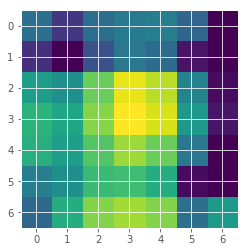

In [19]:
plt.imshow(sample_feature_map[0,:,:,0])

In [20]:
with open('../data/training_data.pkl','rb') as fhdl:
    (out_train_image,out_train_bbs,out_train_imgsize,out_train_masks,out_train_cls_target,out_train_reg_target) = pickle.load(fhdl)

In [21]:
with open('../data/val_data.pkl','rb') as fhdl:
    (out_val_image,out_val_bbs,out_val_imgsize,out_val_masks,out_val_cls_target,out_val_reg_target) = pickle.load(fhdl)

In [22]:
imgindex = random.randint(0,len(out_train_image))
import cv2

In [23]:
class MultiIndex():
    def __init__(self,data):
        self.data = data
    def __getitem__(self,indexs):
        retval = []
        for i in indexs:
            retval.append(self.data[i])
        return retval
    @property
    def shape(self):
        return [len(self.data),]

In [24]:
mi = MultiIndex([1,2,3,4])
mi.shape,mi[[2,3]]

([4], [3, 4])

In [25]:
with open('./data/training_data_box.pkl','rb') as fhdl:
    training_boxes = pickle.load(fhdl)
with open('./data/val_data_box.pkl','rb') as fhdl:
    val_boxes = pickle.load(fhdl)

In [26]:
train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target),
    MultiIndex(training_boxes))

In [27]:
val_dataset = utils.Dataset(
    out_val_image,
    MultiIndex(out_val_masks),
    MultiIndex(out_val_cls_target),
    MultiIndex(out_val_reg_target),
    MultiIndex(val_boxes))

In [28]:
one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)

In [29]:
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]

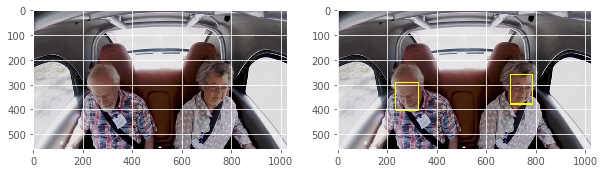

In [30]:

sample_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
for _,idx,idy,idbox in np.asarray(np.where(cls_target[:,:,:,:,1] == 1)).T:
    rx,ry = idx * 32 + 16,idy * 32 + 16
    boxw,boxh = box_tuple[idbox]
    w_delta,h_delta,w_rat,h_rat = reg_target[0,idx,idy,idbox]
    x_center = int(rx + boxw * w_delta)
    y_center = int(ry + boxh * h_delta)
    
    x_width = int(boxw * np.exp(w_rat))
    y_height = int(boxh * np.exp(h_rat))
    
    cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [31]:
if os.path.exists('models/{}'.format(MODEL_NAME)):
    print('dir exists')
else:
    os.mkdir('models/{}'.format(MODEL_NAME))

In [32]:
cls_target[:,:,:,:,1].shape

(1, 32, 17, 9)

In [33]:
np.copy(cls_target[:,:,:,:,1]).shape,one_mask.shape

((1, 32, 17, 9), (1, 32, 17, 9))

In [34]:
def add_random_spot(one_mask):
    one_mask_shape = one_mask.shape
    one_mask = one_mask.reshape(-1)
    if np.sum(one_mask) <= 64:
        num_addmask = 64
    else:
        num_addmask = int(min(np.sum(one_mask),len(one_mask) - np.sum(one_mask)))
    for i in range(num_addmask):
        one_mask[random.randint(0,len(one_mask) - 1)] = 1
    one_mask = one_mask.reshape(one_mask_shape)
    return one_mask

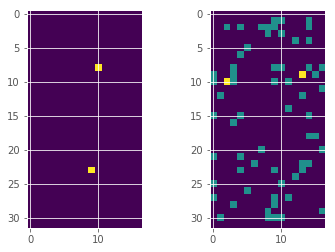

In [35]:
one_mask = np.copy(cls_target[:,:,:,:,1])
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask,-1)[0])
plt.subplot(1,2,2)
plt.imshow(np.sum(add_random_spot(one_mask),-1)[0])

In [36]:
reg_target.shape

(1, 32, 17, 9, 4)

In [37]:
cls_target.shape

(1, 32, 17, 9, 2)

In [38]:
32 * 54 * 9

15552

In [39]:
32 * 54 * 36 // 4

15552

In [40]:
train_epoch = 1
train_batch = 0

In [42]:
start = time.time()
for i in range(100):
    one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
    one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)
end = time.time()
print(end - start)

1.6584174633026123


In [43]:
one_image.shape,one_mask.shape

((1, 1024, 952, 3), (1, 32, 29, 9))

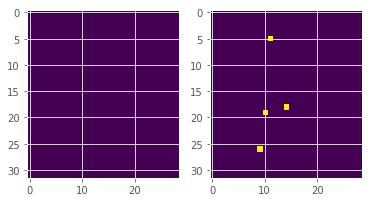

In [44]:
plt.subplot(1,2,1)
plt.imshow(np.sum(one_mask[0],axis=-1))
plt.subplot(1,2,2)
plt.imshow(np.sum(cls_target[:,:,:,:,1][0],axis=-1))

In [46]:
one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)
one_imgurl,one_mask,cls_target,reg_target = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0]
one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
one_image = np.transpose(one_image,[1,0,2])
one_image = np.expand_dims(one_image,0)

one_mask = np.copy(cls_target[:,:,:,:,1])
one_mask = add_random_spot(one_mask)
reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

np.sum(np.sum(sess.run(reg_result,feed_dict={
            learning_rate:batch_lr,
            input_image:one_image,
            mask_input:one_mask,
            cls_input:cls_target,
            reg_input:reg_target
        }).reshape(-1,4),axis=-1) * cls_target[:,:,:,:,1].reshape(-1))

In [47]:
one_cls_result,one_reg_result = sess.run([cls_result,reg_result],feed_dict={
            input_image:one_image,

        })

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c87ad5128>]], dtype=object)

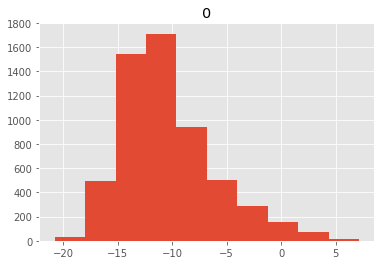

In [48]:
pd.DataFrame(one_cls_result.reshape(-1)).hist()

In [49]:
one_cls_result.shape

(1, 32, 20, 9)

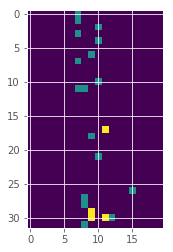

In [50]:
plt.imshow(np.sum(one_cls_result.reshape(32,-1,9) > 4,axis=-1))

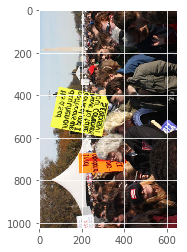

In [51]:
plt.imshow(one_image[0])

In [52]:
one_image.shape

(1, 1024, 648, 3)

In [53]:
one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])

In [54]:
from nms import non_max_suppression_fast

In [55]:
np.argsort([1,2,3])

array([0, 1, 2])

In [56]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [62]:
def xywharr2xyxyarr(one_box):
    one_box = np.asarray(one_box)[:,:4]
    one_box[:,2] += one_box[:,0]
    one_box[:,3] += one_box[:,1]
    return one_box

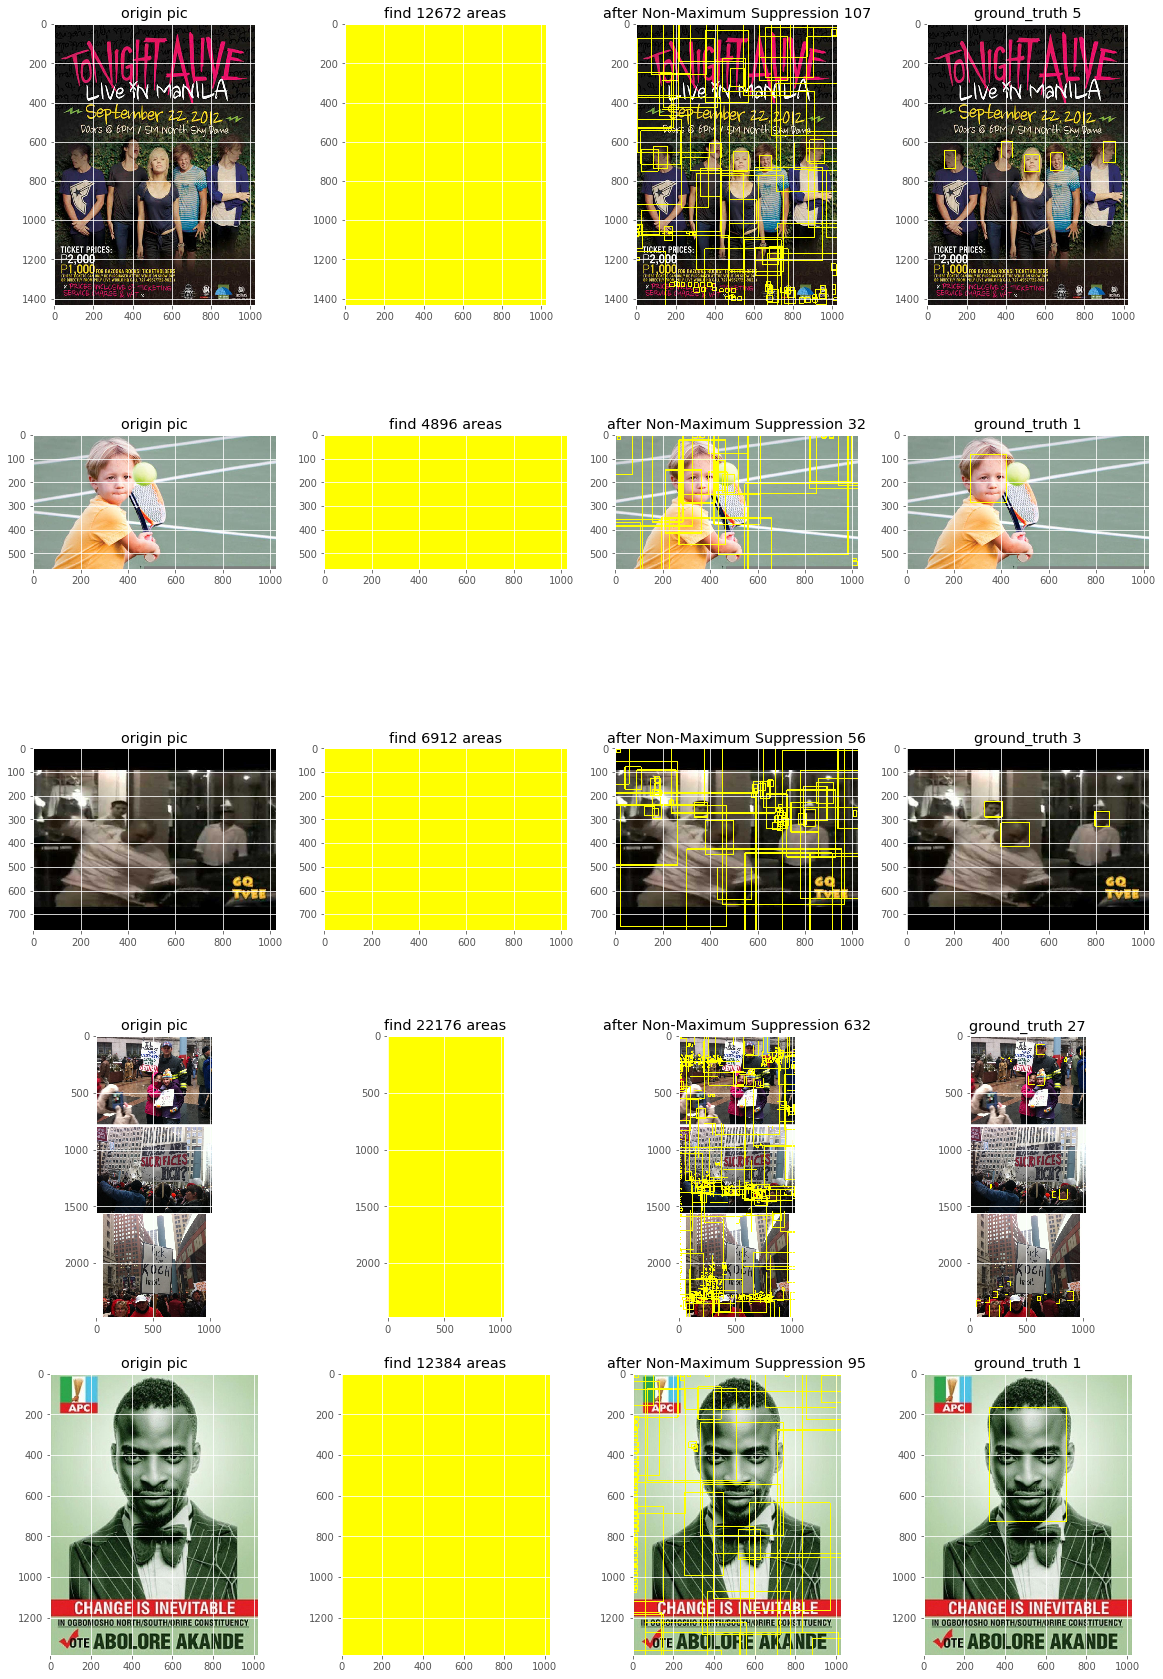

In [189]:
import cv2
pic_num = 5
plt.figure(figsize=(20,30))
for i in range(1,pic_num + 1):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image = np.transpose(one_image,[1,0,2])
    one_image = np.expand_dims(one_image,0)

    one_mask = np.copy(cls_target[:,:,:,:,1])
    one_mask = add_random_spot(one_mask)
    reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

    one_cls_result,one_reg_result,batch_bb_indexs,batch_bb_probs,batch_bb_reg,batch_rpn_box,batch_boxind,batch_boxnorm, \
        batch_nms_box_index,batch_nms_boxes,batch_nms_groundtruth_iou_matrix,batch_groundtruth_box_norm,\
        batch_roi_cls_target,batch_roi_reg_target = \
        sess.run([cls_result,reg_result,bb_indexs,bb_probs,bb_reg,rpn_boxes,rpn_box_index,rpn_boxes_norm,\
                 nms_box_index,nms_boxes,nms_groundtruth_iou_matrix,groundtruth_box_norm,\
                 roi_cls_target,roi_reg_target],feed_dict={
                input_image:one_image,
                groundtruth_box:xywharr2xyxyarr(one_box),
            })
    one_reg_result = one_reg_result.reshape(list(one_reg_result.shape[:-1]) + [9,4])

    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    number_of_box = 100
    threshold = sorted(one_cls_result.reshape(-1))[-number_of_box]
    threshold = 0.0
    boxes = []
    boxprob = []

    
    plt.subplot(pic_num,4,1 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title('origin pic')
    for _,idx,idy,idbox in np.asarray(np.where(sigmoid(one_cls_result) > threshold)).T:
        rx,ry = idx * 32 + 16,idy * 32 + 16
        boxw,boxh = box_tuple[idbox]
        w_delta,h_delta,w_rat,h_rat = one_reg_result[0,idx,idy,idbox]
        x_center = int(rx + boxw * w_delta)
        y_center = int(ry + boxh * h_delta)

        x_width = int(boxw * np.exp(w_rat))
        y_height = int(boxh * np.exp(h_rat))

        cv2.rectangle(sample_image,(x_center - x_width // 2,y_center - y_height // 2),(x_center + x_width // 2,y_center + y_height // 2),(256,256,0),4)
        boxes.append((x_center - x_width // 2,y_center - y_height // 2,x_center + x_width // 2,y_center + y_height // 2))
        boxprob.append(one_cls_result[0,idx,idy,idbox])
    plt.subplot(pic_num,4,2 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("find {} areas".format( len(np.asarray(np.where(sigmoid(one_cls_result) > threshold)).T)))

    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    boxes = np.asarray(boxes)
    boxprob = sigmoid(np.asarray(boxprob))
    superssed_box = non_max_suppression_fast(boxes,0.4,probs=boxprob)
    for x1,y1,x2,y2 in superssed_box:
        cv2.rectangle(sample_image,(x1,y1),(x2,y2),(256,256,0),4)
    plt.subplot(pic_num,4,3 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("after Non-Maximum Suppression {}".format(len(superssed_box)))
    
    
    sample_image = np.copy(np.transpose(one_image[0],[1,0,2]))
    for m in one_box:
        x,y,w,h = m[:4]
        cv2.rectangle(sample_image,(x,y),(x + w,y + h),(256,256,0),4)
    plt.subplot(pic_num,4,4 + (i - 1) * 4)
    plt.imshow(sample_image)
    plt.title("ground_truth {}".format(len(one_box)))

In [181]:
len(batch_boxind),len(batch_nms_box_index)

(6048, 100)

In [182]:
batch_roi_cls_target

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [676]:
np.asarray(one_box)[:,:4]

array([[541, 252,  62, 114]])

In [677]:
one_image.shape

(1, 1024, 1221, 3)

In [697]:
batch_nms_boxes[1]

array([ 0.36266127,  0.34830803,  0.37474629,  0.36627501], dtype=float32)

In [621]:
batch_groundtruth_box_norm

array([[ 0.41015625,  0.1443433 ,  0.64160156,  0.33940181]], dtype=float32)

In [533]:
one_box

[[301, 208, 217, 292, 0, 0, 0, 0, 0, 0]]

In [718]:
batch_nms_groundtruth_iou_matrix[:10]

array([[ 0.733181  ],
       [ 0.        ],
       [ 0.        ],
       [ 0.18722367],
       [ 0.        ],
       [ 0.        ],
       [ 0.18542184],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [623]:
cal_iou(batch_nms_boxes[0],batch_groundtruth_box_norm[0])

0.73333009832599383

In [625]:
batch_roi_cls_target[0],batch_roi_reg_target[0]

(1, array([-0.06926046, -0.09507146,  0.07579513,  0.05384519], dtype=float32))

In [631]:
(0.43346322 + 0.64801443) / 2 + (0.64801443 - 0.43346322) * -0.06926046,(0.41015625 + 0.64160156) / 2

(0.5258789095018435, 0.525878905)

In [632]:
(0.64801443 - 0.43346322) * np.exp(0.07579513),(0.64160156 - 0.41015625)

(0.23144530477316105, 0.23144531000000002)

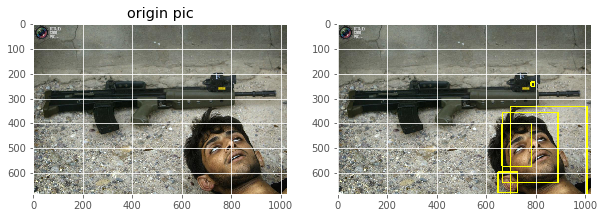

In [183]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
si = np.copy(np.transpose(one_image[0],[1,0,2]))
plt.imshow(si)
plt.title('origin pic')
for x1,y1,x2,y2 in batch_nms_boxes[:5]:
    x1 = x1 * sample_image.shape[1]
    x2 = x2 * sample_image.shape[1]
    y1 = y1 * sample_image.shape[0]
    y2 = y2 * sample_image.shape[0]
    x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
    cv2.rectangle(si,(x1,y1),(x2,y2),(255,255,0),4)
plt.subplot(1,2,2)
plt.imshow(si)

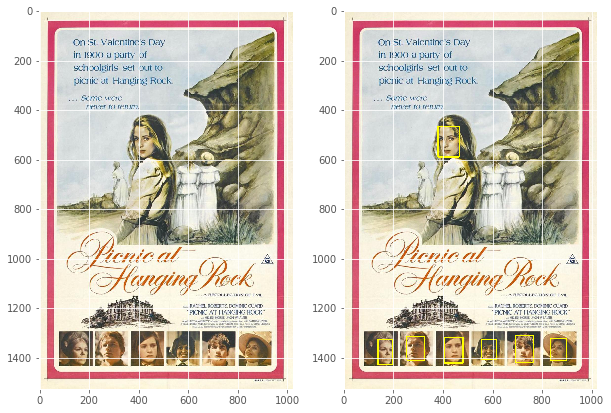

In [60]:
randindex = random.randint(0,len(training_boxes))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sample_image = plt.imread('../data/WIDER_train/images/' + out_train_image[randindex])
plt.imshow(sample_image)
for i in training_boxes[randindex]:
    x1,y1,w,h = i[:4]
    cv2.rectangle(sample_image,(x1,y1),(x1 + w,y1 + h),(256,256,0),4)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [134]:
train_epoch = 1
train_batch = 0

In [79]:
from nms import non_max_suppression_fast

In [80]:
def xywh2xyxy(incord):
    return incord[0],incord[1],incord[0] + incord[2],incord[1] + incord[3]

def cal_iou(box1,box2):
    x11,y11,x12,y12 = box1
    x21,y21,x22,y22 = box2
    x1 = max(x11,x21)
    x2 = min(x12,x22)
    y1 = max(y11,y21)
    y2 = min(y12,y22)
    rect_w = max(0,x2 - x1)
    rect_h = max(0,y2 - y1)
    iou = rect_w * rect_h / ((x12 - x11) * (y12 - y11) + (x22 - x21) * (y22 - y21) + 1e-7 - rect_w * rect_h)
    return iou

def twocord2centercord(thisx,thisy,thisx1,thisy1):
    this_cx = (thisx + thisx1) // 2
    this_cy = (thisy + thisy1) // 2
    this_w = (thisx1 - thisx)
    this_h = (thisy1 - thisy)
    return this_cx,this_cy,this_w,this_h

def get_four_tterms(targetcord,thiscord):
    thisx,thisy,thisx1,thisy1 = thiscord
    targetx,targety,targetx1,targety1 = targetcord
    
    this_cx,this_cy,this_w,this_h = twocord2centercord(thisx,thisy,thisx1,thisy1)
    target_cx,target_cy,target_w,target_h = twocord2centercord(targetx,targety,targetx1,targety1)
    
    tx = (target_cx - this_cx) / this_w
    ty = (target_cy - this_cy) / this_h
    tw = np.log(target_w / this_w)
    th = np.log(target_h / this_h)
    return tx,ty,tw,th

def cal_roi_target(boxes,groundtruth_boxs,iou_threshold=0.5):
    out_reg_result = np.zeros((len(boxes),4))
    out_cls_result = np.zeros((len(boxes),1))
    for ind,one_box in enumerate(boxes):
        max_box,max_iou = None,None
        for one_gtbox in groundtruth_boxs:
            if len(one_gtbox) > 4:
                one_gtbox = xywh2xyxy(one_gtbox)
            box_iou = cal_iou(one_box,one_gtbox)
            if max_iou is None or box_iou > max_iou:
                max_iou = box_iou
                max_box = one_gtbox
            # generate cls result and reg result
        if max_iou > iou_threshold:
            out_cls_result[ind,0] = 1
            tx,ty,tw,th = get_four_tterms(one_box,max_box)
            out_reg_result[ind] = np.asarray([tx,ty,tw,th])
        else:
            out_cls_result[ind,0] = 0
    return out_cls_result,out_reg_result

In [203]:
len(one_box)

1

In [236]:
restore = True
EPOCHS = 20
BATCH_PER_EPOCH = len(train_images) // BATCH_SIZE
begining_learning_rate = 5e-5
decay_epoch = 10

for one_epoch in range(train_epoch,EPOCHS + 1):
    train_dataset = utils.Dataset(
    out_train_image,
    MultiIndex(out_train_masks),
    MultiIndex(out_train_cls_target),
    MultiIndex(out_train_reg_target),
    MultiIndex(training_boxes))
    
    pb = utils.ProgressBar(worksum=BATCH_PER_EPOCH // 2)
    pb.startjob()
    for one_batch in range(1,BATCH_PER_EPOCH // 2 + 1):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(1)
            pb.auto_display = True
            continue
        else:
            restore = False
        one_imgurl,one_mask,cls_target,reg_target,one_box = train_dataset.next_batch(1)
        one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
        one_image = plt.imread('../data/WIDER_train/images/{}'.format(one_imgurl))
        one_image = np.transpose(one_image,[1,0,2])
        one_image = np.expand_dims(one_image,0)
        
        if len(one_box) == 0 or np.any(np.asarray(one_box)[:,2:4] == 0):
            continue
        try:
            batch_lr = begining_learning_rate * 0.5 ** (max(one_epoch - decay_epoch + 1,0))
            one_mask = np.copy(cls_target[:,:,:,:,1])
            one_mask = add_random_spot(one_mask)
            reg_target = reg_target.reshape(list(reg_target.shape[:3]) + [-1,])

            one_cls_result,one_reg_result,_,\
                batch_cls_loss,batch_reg_loss,batch_total_loss,step_value,batch_train_summary_op,\
                batch_roi_cls_loss,batch_roi_reg_loss,batch_roi_total_loss,batch_summary_op_roi \
                = sess.run([cls_result,reg_result,train_op_roi,\
                            cls_loss,reg_loss,total_loss,global_step,summary_op,\
                           roi_cls_loss,roi_reg_loss,roi_total_loss,summary_op_roi],feed_dict={
                learning_rate_roi:batch_lr,
                learning_rate:batch_lr,
                input_image:one_image,
                mask_input:one_mask,
                cls_input:cls_target[:,:,:,:,1],
                reg_input:reg_target,
                groundtruth_box:xywharr2xyxyarr(one_box),
            })
            
            pb.info = "EPOCH {} BATCH {} lr {} cls_lo {:.2f} reg_lo {:.2f} total_lo {:.2f} roi_cls {:.2f} roi_reg {:.2f} roi_total {:.2f}".format(one_epoch,one_batch,
                    batch_lr,batch_cls_loss,batch_reg_loss,batch_total_loss,batch_roi_cls_loss,batch_roi_reg_loss,batch_roi_total_loss)
            train_summary_writer.add_summary(batch_train_summary_op,step_value)
            train_summary_writer.add_summary(batch_summary_op_roi,step_value)
        except (KeyboardInterrupt,SystemExit):
            raise
        except:
            traceback.print_exc()
            
            print()
            print()
            break
        if(np.isnan(batch_roi_reg_loss)):
                ddbb
        pb.complete(1)
    with graph.as_default():
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))
    
    print()

EPOCH 1 BATCH 6440 lr 5e-05 cls_lo 0.02 reg_lo 0.04 total_lo 0.06 roi_cls 0.08 roi_reg 0.04 roi_total 0.12 99.86 % [=================================================>-] 6431/6440 	 used:2185s eta:3 ss sss
EPOCH 2 BATCH 6440 lr 5e-05 cls_lo 0.02 reg_lo 0.01 total_lo 0.03 roi_cls 0.08 roi_reg 0.01 roi_total 0.09 99.84 % [=================================================>-] 6430/6440 	 used:2180s eta:3 s ssss
EPOCH 3 BATCH 6440 lr 5e-05 cls_lo 1.70 reg_lo 0.25 total_lo 1.95 roi_cls 0.20 roi_reg 0.04 roi_total 0.24 99.86 % [=================================================>-] 6431/6440 	 used:2180s eta:3 ss sss
EPOCH 4 BATCH 6440 lr 5e-05 cls_lo 0.42 reg_lo 0.19 total_lo 0.61 roi_cls 0.09 roi_reg 0.01 roi_total 0.10 99.86 % [=================================================>-] 6431/6440 	 used:2179s eta:3 sss ss
EPOCH 5 BATCH 6440 lr 5e-05 cls_lo 0.06 reg_lo 0.26 total_lo 0.32 roi_cls 0.05 roi_reg 0.03 roi_total 0.08 99.88 % [=================================================>-] 6432/6440 	

KeyboardInterrupt: 

In [234]:
one_box

[[867, 164, 0, 1, 1, 0, 0, 0, 0, 0],
 [915, 61, 21, 26, 1, 0, 0, 0, 0, 0],
 [783, 87, 21, 26, 1, 0, 0, 0, 0, 0]]

In [232]:
np.asarray(one_box)[:,:4]

array([[306, 243,  60,  68],
       [514, 232,  48,  66],
       [626, 258,  55,  51],
       [730, 280,  37,  33]])

In [213]:
one_imgurl

'46--Jockey/46_Jockey_Jockey_46_576.jpg'

In [216]:
err_case= list({
                learning_rate_roi:batch_lr,
                learning_rate:batch_lr,
                input_image:one_image,
                mask_input:one_mask,
                cls_input:cls_target[:,:,:,:,1],
                reg_input:reg_target,
                groundtruth_box:xywharr2xyxyarr(one_box),
            }.values())

In [226]:
np.all(np.asarray(one_box) == 0)

True

In [487]:
with graph.as_default():
    saver = tf.train.Saver(tf.global_variables())
    saver.save(sess,"models/{}/model_latest".format(MODEL_NAME))

In [240]:
batch_nms_boxes,batch_roi_cls_result = sess.run([nms_boxes,roi_cls_result],feed_dict={
                input_image:one_image,
                #groundtruth_box:xywharr2xyxyarr(one_box),
            })

In [241]:
batch_nms_boxes[:10]

array([[ 0.30648667,  0.09673889,  0.48360246,  0.29421252],
       [ 0.72641134,  0.05409399,  0.85429776,  0.1992753 ],
       [ 0.70719123,  0.48637527,  0.78691983,  0.56285512],
       [ 0.76714611,  0.0759052 ,  0.86658466,  0.16174813],
       [ 0.05339891, -0.02965327,  0.53418428,  0.42203489],
       [ 0.804308  ,  0.43675393,  0.88240522,  0.52156192],
       [ 0.76446426,  0.44805872,  0.89785075,  0.59812808],
       [ 0.75159097,  0.40146351,  0.7675159 ,  0.41651228],
       [ 0.04706642,  0.15218168,  0.18232739,  0.28679428],
       [ 0.67178792,  0.00715363,  0.87910396,  0.24332453]], dtype=float32)

In [244]:
sigmoid(batch_roi_cls_result)[:10]

array([[ 0.87511843],
       [ 0.57041109],
       [ 0.84466243],
       [ 0.40164447],
       [ 0.05391404],
       [ 0.12553556],
       [ 0.00676336],
       [ 0.00267765],
       [ 0.19122013],
       [ 0.14541025]], dtype=float32)

In [312]:
def delta_to_box(roi_box,roi_delta,input_img_shape):
    x_center = (roi_box[:,0] + roi_box[:,2]) / 2
    y_center = (roi_box[:,1] + roi_box[:,3]) / 2
    
    w = (roi_box[:,2] - roi_box[:,0])
    h = (roi_box[:,3] - roi_box[:,1])
    
    x_center = x_center + w * roi_delta[:,0]
    y_center = y_center + h * roi_delta[:,1]
    w = w * tf.exp(roi_delta[:,2])
    h = h * tf.exp(roi_delta[:,3])
    
    x1,y1,x2,y2 = x_center - w / 2,y_center - h / 2,x_center + w / 2,y_center + h / 2
    return tf.cast(tf.stack([x1,y1,x2,y2],axis=1) * tf.cast(tf.concat([input_img_shape,input_img_shape],axis=0),tf.float32),tf.int32)

In [365]:
roi_true_index = tf.where(roi_cls_result > 0.3)[:,0]
roi_box = tf.gather(nms_boxes,roi_true_index)
roi_delta = tf.gather(roi_reg_result,roi_true_index)

roi_finalbox = delta_to_box(roi_box,roi_delta,input_img_shape)
roi_finalprob = tf.gather(tf.sigmoid(roi_cls_result),roi_true_index)
nms_finalbox = tf.cast(nms_boxes * tf.cast(tf.concat([input_img_shape,input_img_shape],axis=0),tf.float32),tf.int32)

roi_nms_boxindex = tf.image.non_max_suppression(tf.cast(roi_finalbox,tf.float32) / tf.cast(tf.concat([input_img_shape,input_img_shape],axis=0),tf.float32),roi_finalprob[:,0],max_output_size=100,iou_threshold=0.3)
roi_nms_finalbox = tf.gather(roi_finalbox,roi_nms_boxindex)
roi_nms_finalprob = tf.gather(roi_finalprob,roi_nms_boxindex)

In [455]:
?cv2.putText()

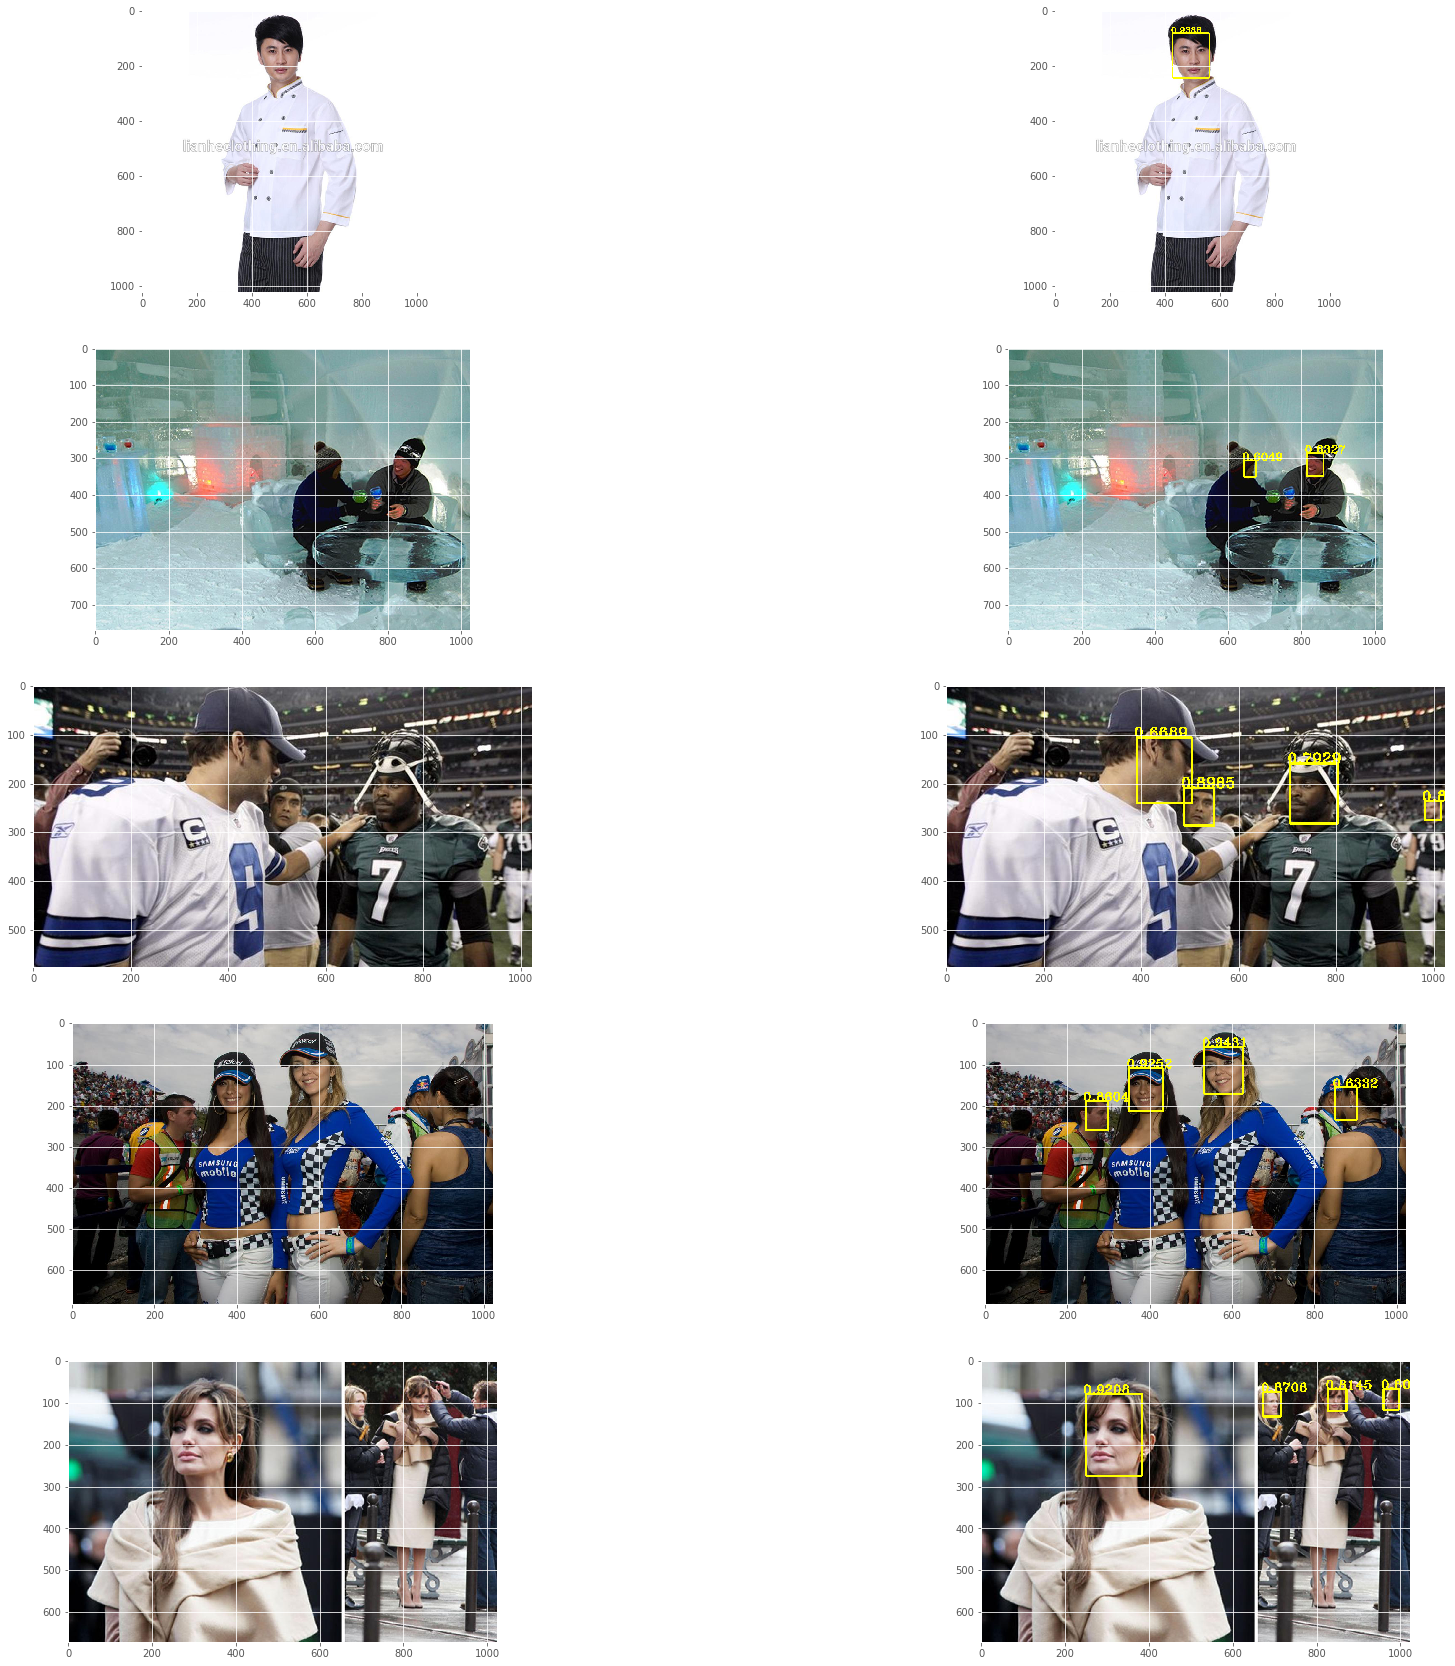

In [485]:
num_pics = 5
plt.figure(figsize=(30,30))
for i in range(num_pics):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image_tr = np.transpose(one_image,[1,0,2])
    one_image_tr = np.expand_dims(one_image_tr,0)


    result_finalbox,result_roi_finalprob,result_nmsbox = sess.run([roi_nms_finalbox,roi_nms_finalprob,nms_finalbox],feed_dict={
                    input_image:one_image_tr,
                    #groundtruth_box:xywharr2xyxyarr(one_box),
                })

    
    plt.subplot(num_pics,2,i * 2 + 1)
    plt.imshow(one_image)

    plt.subplot(num_pics,2,i * 2 + 2)
    for (x1,y1,x2,y2),prob in zip(result_finalbox,result_roi_finalprob):
        cv2.rectangle(one_image,(x1,y1),(x2,y2),(255,255,0),4)
        cv2.putText(one_image, str("{:.4f}".format(prob[0])), (x1 - 6, y1), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 0), 2, False)
    plt.imshow(one_image)

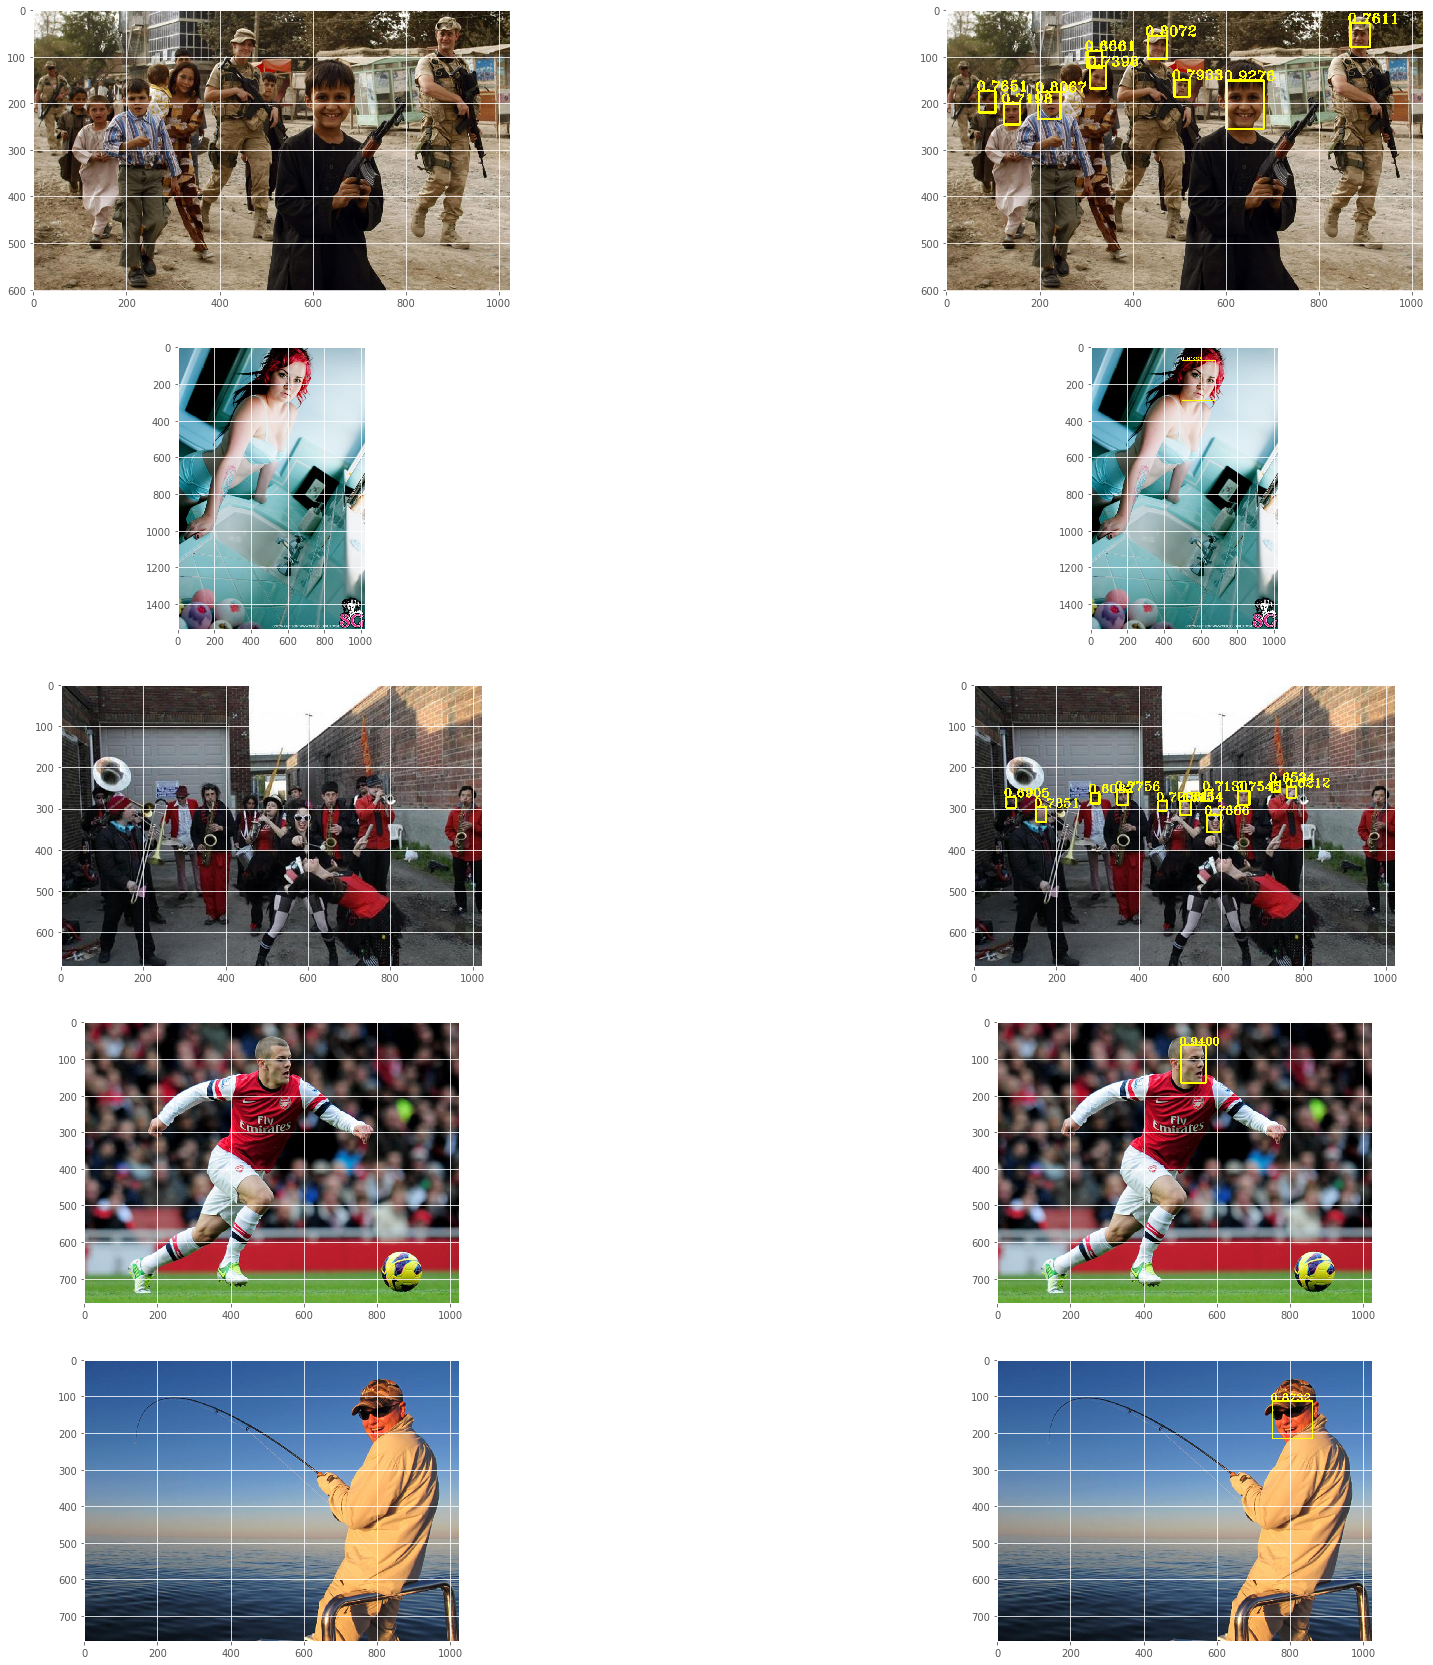

In [499]:
num_pics = 5
plt.figure(figsize=(30,30))
for i in range(num_pics):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image_tr = np.transpose(one_image,[1,0,2])
    one_image_tr = np.expand_dims(one_image_tr,0)


    result_finalbox,result_roi_finalprob,result_nmsbox = sess.run([roi_nms_finalbox,roi_nms_finalprob,nms_finalbox],feed_dict={
                    input_image:one_image_tr,
                    #groundtruth_box:xywharr2xyxyarr(one_box),
                })

    
    plt.subplot(num_pics,2,i * 2 + 1)
    plt.imshow(one_image)

    plt.subplot(num_pics,2,i * 2 + 2)
    for (x1,y1,x2,y2),prob in zip(result_finalbox,result_roi_finalprob):
        cv2.rectangle(one_image,(x1,y1),(x2,y2),(255,255,0),4)
        cv2.putText(one_image, str("{:.4f}".format(prob[0])), (x1 - 6, y1), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 0), 2, False)
    plt.imshow(one_image)

In [495]:
time1 = time.time()
for i in range(100):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image_tr = np.transpose(one_image,[1,0,2])
    one_image_tr = np.expand_dims(one_image_tr,0)


    #result_finalbox,result_roi_finalprob,result_nmsbox = sess.run([roi_nms_finalbox,roi_nms_finalprob,nms_finalbox],feed_dict={
    #                input_image:one_image_tr,
    #                #groundtruth_box:xywharr2xyxyarr(one_box),
    #            })
load_time = time.time() - time1

In [496]:
time1 = time.time()
for i in range(100):
    one_imgurl,one_mask,cls_target,reg_target,one_box = val_dataset.next_batch(1)
    one_imgurl,one_mask,cls_target,reg_target,one_box = one_imgurl[0],one_mask[0],cls_target[0],reg_target[0],one_box[0]
    one_image = plt.imread('../data/WIDER_val/images/{}'.format(one_imgurl))
    one_image_tr = np.transpose(one_image,[1,0,2])
    one_image_tr = np.expand_dims(one_image_tr,0)


    result_finalbox,result_roi_finalprob,result_nmsbox = sess.run([roi_nms_finalbox,roi_nms_finalprob,nms_finalbox],feed_dict={
                    input_image:one_image_tr,
                    #groundtruth_box:xywharr2xyxyarr(one_box),
                })
run_time = time.time() - time1

In [503]:
"{:.4f} fps".format(100 / (run_time - load_time))

'9.9008 fps'